<a href="https://colab.research.google.com/github/nh945/CircularKernel/blob/main/%E2%80%9CLoFTR_demo_single_pair_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LoFTR demo with custom image pairs on Colab
We provide an easier way to run LoFTR with a custom image pair without configuring a python environment with GPU support. Signing in your Google account is required to run this notebook in Colab.

Start by clicking Runtime --> Run all (Ctrl/Cmd + F9). 

Upload your own image pair with the "Choose Files" button to appear in the first cell. Please use horizontal images (width > height) and assign the image type (indoor/outdoor) accordingly.

In [ ]:
print("Please wait for ~8 seconds for the GPU session initialization. \n \
==> Please select both images at the same time after clicking \"Choose Files\".")
!mkdir -p /content/uploaded/ && rm -rf /content/uploaded/* # clear previously uploaded images
%cd /content/uploaded/
from google.colab import files
uploaded = files.upload()

for file_name in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=file_name, length=len(uploaded[file_name])))
image_pair = ['/content/uploaded/' + f for f in list(uploaded.keys())]
%cd ..

# Change the image type here.
image_type = 'indoor'
image_type = 'outdoor'

Please wait for ~8 seconds for the GPU session initialization. 
 ==> Please select both images at the same time after clicking "Choose Files".
/content/uploaded


Saving per_89.png to per_89.png
Saving sar_89.png to sar_89.png
Saving true_89.png to true_89.png
User uploaded file "per_89.png" with length 125885 bytes
User uploaded file "sar_89.png" with length 141956 bytes
User uploaded file "true_89.png" with length 127661 bytes
/content


You can also choose to use the example image pair provided in the LoFTR repo (from ScanNet) by using this cell (uncommenting the last line).


In [ ]:
img0_pth = "assets/scannet_sample_images/scene0711_00_frame-001680.jpg"
img1_pth = "assets/scannet_sample_images/scene0711_00_frame-001995.jpg"
image_pair = [img0_pth, img1_pth, img2_pth]
image_pair = [img1_pth, img0_pth, img2_pth]

In [ ]:
# Configure environment and grab LoFTR code.
!rm -rf sample_data
!pip install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

# Download pretrained weights
!mkdir weights 
%cd weights/
!gdown --id 1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O  # indoor-ds
!gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds
%cd ..

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'LoFTR' already exists and is not an empty directory.
mv: cannot move 'LoFTR/assets' to './assets': Directory not empty
mv: cannot move 'LoFTR/configs' to './configs': Directory not empty
mv: cannot move 'LoFTR/data' to './data': Directory not empty
mv: cannot move 'LoFTR/demo' to './demo': Directory not empty
mv: cannot move 'LoFTR/docs' to './docs': Directory not empty
mv: cannot move 'LoFTR/notebooks' to './notebooks': Directory not empty
mv: cannot move 'LoFTR/scripts' to './scripts': Directory not empty
mv: cannot move 'LoFTR/src' to './src': Directory not empty
mv: cannot move 'LoFTR/third_party' to './third_party': Directory not empty
mkdir: cannot create directory ‘weights’: File exists
/content/weights
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't 

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import measure
from skimage import transform
from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

In [ ]:
# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
if image_type == 'indoor':
  matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])
elif image_type == 'outdoor':
  matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
else:
  raise ValueError("Wrong image_type is given.")
matcher = matcher.eval().cuda()

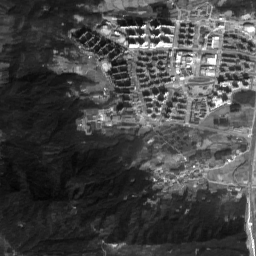

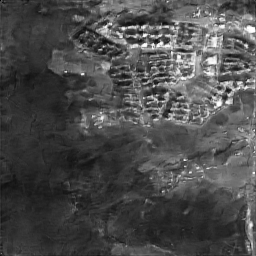

/content/src/loftr/utils/coarse_matching.py:246: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
/content/src/loftr/utils/coarse_matching.py:249: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % data['hw1_c'][1], j_ids // data['hw1_c'][1]],


In [ ]:
# Rerun this cell (and below) if a new image pair is uploaded.

img0_raw = cv2.imread(image_pair[2], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
cv2_imshow(img0_raw)
cv2_imshow(img1_raw)
img0_raw = cv2.resize(img0_raw, (256, 256))
img1_raw = cv2.resize(img1_raw, (256, 256))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

In [ ]:
print(image_pair)

['/content/uploaded/per_89.png', '/content/uploaded/sar_89.png', '/content/uploaded/true_89.png']


(500, 2)
match num is 485
(485, 2)
(485, 2)
90.25052039221077
0.18608354720043457
(256, 256)


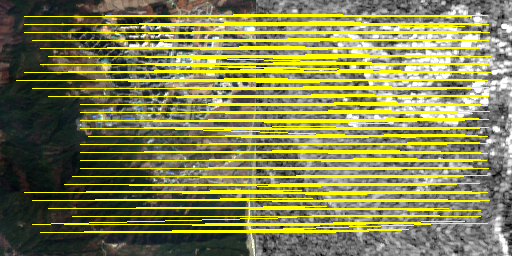

In [ ]:
# Draw 
color = cm.jet(mconf, alpha=0)
print(mkpts0.shape)
locations_1_to_use = np.array(mkpts0)
locations_2_to_use = np.array(mkpts1)

def image_compose(img0, img1, w1, h1, w2, h2, s):
    to_image = Image.new('RGB', ((w1 + w2 + s), h2), color=(255, 255, 255))  # 创建一个新图
    to_image.paste(img0, (0, int(h2 / 2) - int(h1 / 2)))
    to_image.paste(img1, (w1 + s, 0))
    return to_image  # 新图

_RESIDUAL_THRESHOLD = 10
H, inliers = measure.ransac((locations_1_to_use, locations_2_to_use),
                                    transform.AffineTransform,
                                    min_samples=3,
                                    residual_threshold=_RESIDUAL_THRESHOLD,
                                    max_trials=1000)

inlier_idxs = np.nonzero(inliers)[0]  # 返回数组第一维中非零元素的索引值
locations_1_to_use = locations_1_to_use.tolist()
locations_2_to_use = locations_2_to_use.tolist()
locations_1_to_use1 = []
locations_2_to_use1 = []
for g in inlier_idxs:
   locations_1_to_use1.append(locations_1_to_use[g])
   locations_2_to_use1.append(locations_2_to_use[g])
print('match num is %d' % len(locations_1_to_use1))
locations_1_to_use1 = np.array(locations_1_to_use1)
locations_2_to_use1 =np.array(locations_2_to_use1)
print(locations_1_to_use1.shape)
print(locations_2_to_use1.shape)
cnngood11 = locations_1_to_use1 
cnngood22 = locations_2_to_use1

h15 = np.array([[1.00295, 0.000544, -1.45334], [-0.00198, 0.98426, 2.96710], [0, 0, 1]])
h89 = np.array([[0.99676, 0.03725, -2.91768], [0.00876, 1.00584, -2.95667], [0, 0, 1]])
h166 = np.array([[1.00842, 0.03528, -7.73069], [0.02943, 0.92355, 9.25211], [0, 0, 1]])
h187 = np.array([[1.00928, 0.02158, -3.02478], [-0.00568, 1.00018, -0.31638], [0, 0, 1]])

zuobiao = (np.insert(cnngood11, 2, values=1, axis=1))  # 左图参考图像坐标
zuobiao1 = np.dot(zuobiao, h187)
zuobiao1 = zuobiao1[:, 0:2]
ncmp = abs((zuobiao1[:, 0] - cnngood22[:, 0]) + (zuobiao1[:, 1] - cnngood22[:, 1]))
ncmp1 = np.array(np.where(ncmp <= 3))
error1 = sum((cnngood22[:, 0] - zuobiao1[:, 0]) ** 2)
error2 = sum((cnngood22[:, 1] - zuobiao1[:, 1]) ** 2)
Q = np.sqrt(error1 + error2)
print(Q)
E = Q / len(locations_1_to_use1)
print(E)


mkpts0 =locations_1_to_use1
mkpts1 = locations_2_to_use1
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]

img0_raw1 = cv2.imread(image_pair[2])
img1_raw1 = cv2.imread(image_pair[1])
w1, h1,c = img0_raw1.shape
w2, h2,c = img1_raw1.shape
print(img1_raw.shape)
s1 = 0
all_img = np.asarray(image_compose(Image.fromarray(img0_raw1), Image.fromarray(img1_raw1), w1, h1, w2, h2, s1))
for k in range(len(locations_1_to_use1)):
          cv2.line(all_img,(int(locations_1_to_use1[k][0]), int(locations_1_to_use1[k][1] + (int(h2 / 2) - int(h1 / 2)))),
              (int(locations_2_to_use1[k][0]) + w1 + s1, int(locations_2_to_use1[k][1])), (0, 255, 255), 1)
cv2_imshow(all_img)









